In [1]:
import json
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import wordcloud
import numpy as np
%matplotlib inline
import tweepy as tw
from nltk.twitter.common import json2csv
import matplotlib 
matplotlib.style.use('bmh')

### 1. 数据获取
- **(1) tweepy 接入 twitter API**：   
在 twitter 官网获得 consumer_key, consumer_secret, access_token, access_secret 后通过 Oauth 接入 API
- **(2) tweepy.streaming 爬入数据**：   
这里设置导出数据的json文件，表明要爬取的数据标签 #brexit

In [2]:
import tweepy
from tweepy import OAuthHandler
 
consumer_key = 'eLib6Cdsf3q9RkkXEPr7mFJffBTC5gW'
consumer_secret = 'r2NMPdsfp2zE51637l5Iv97wewMsKAiJR4rvP2LkSpto5BVadvfBKcNtF'
access_token = '38733619ds4f37-jNd8gljANXXewew07oUeD4QrlAuLv7O31a2qScH1MB1'
access_secret = 'lgmYrAEYc505ElKPOqO2RwewwelyD4PKRVmvJBKGWmeHCDBahmG'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [306]:
from tweepy import Stream
from tweepy.streaming import StreamListener
 
class MyListener(StreamListener):
 
    def on_data(self, data):
        try:
            with open('brexit05july.json', 'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
 
    def on_error(self, status):
        print(status)
        return True
 
twitter_stream = Stream(auth, MyListener())
twitter_stream.filter(track=['brexit'])

## 数据清理
### 1. Json 转 CSV
- **(1) Json 转 csv 工具**：   
用到 nltk.twitter.common 中的 json2csv 包   
可根据需要选择要保留的变量

In [35]:
from nltk.twitter.common import json2csv
with open('python.json') as fp:
    json2csv(fp, 'python_tweet.csv', ['text'])

- **(2) Json 转 csv 可选择的保留项：** 
    - text: 推文
    - created_at: 发推时间
    - favorite_count, retweet_count: 被收藏和被转推次数
    - favorited, retweeted: 自己是否转推和收藏过某推文
    - lang: 语言选择
    - id: 推特账户ID
    - place, coordinates, geo: 地点和经纬度坐标数据
    - user: 推文作者的简介
    - entities: @和＃的标签内容
    - in_reply_to_user_id: 推文是否回复了某一特定用户
    - in_reply_to_status_id: 回复的特定用户ID

In [ ]:
with open('python.json') as fp:
    json2csv(fp, 'python_tweet.csv',
            ['created_at', 'favorite_count', 'id', 'in_reply_to_status_id', 
            'in_reply_to_user_id', 'retweet_count', 'retweeted', 
            'text'])

- **(3) meta-data **   
    把原本的csv 切割得更细化 

In [77]:
from nltk.twitter.common import json2csv_entities
with open('python.json') as fp:
    json2csv_entities(fp, 'tweets.20150430-223406.hashtags.csv',
                        ['id', 'text'], 'hashtags', ['text'])
    
with open('python.json') as fp:
    json2csv_entities(fp, 'tweets.20150430-223406.user_mentions.csv',
                        ['id', 'text'], 'user_mentions', ['id', 'screen_name'])
    
with open('python.json') as fp:
    json2csv_entities(fp, 'tweets.20150430-223406.media.csv',
                        ['id'], 'media', ['media_url', 'url'])
    
with open('python.json') as fp:
    json2csv_entities(fp, 'tweets.20150430-223406.urls.csv',
                        ['id'], 'urls', ['url', 'expanded_url'])
    
with open('python.json') as fp:
    json2csv_entities(fp, 'tweets.20150430-223406.place.csv',
                        ['id', 'text'], 'place', ['name', 'country'])

with open('python.json') as fp:
    json2csv_entities(fp, 'tweets.20150430-223406.place_bounding_box.csv',
                        ['id', 'name'], 'place.bounding_box', ['coordinates'])

### 2. 文本基本清理
- **(1) 分词 nltk.word_tokenize() **    
进行文本分析之前，需要把大单位的句子转为小单位的单词，才能继续进行分析  
  
- **(2) 去除 stopwords 停止词、标点符号、单复数和字符长度小于3的无意义字符**
    - ** stopwords 停止词 － nltk.corpus.stopwords.words('english')**：   
         去除常见连词、代词、语气助词等
    - ** 标点符号 string.punctuation**：    
    - ** 短字符 **：如 rt, co 之类的无意义短或空字符
    - ** 单复数 nltk.stem.PorterStemmer**：

#### 分词 tokenization
- 读取文件，下面为直接读取json文件的例子

In [3]:
with file("brexit1.json",'r') as handle:
    text = handle.read()

In [4]:
text[0:100]

'48% is suddenly enough to keep us in Europe. #WAL #brexit https://t.co/G089bDC6cj\r\n"Tories declaring'

- 分词

In [5]:
import nltk
tokens = nltk.word_tokenize(text)
tokens[60:66]

['next', 'election', '.', 'We', 'will', 'have']

#### 停止词 StopWords

In [6]:
from nltk.corpus import stopwords

In [7]:
english_stops = stopwords.words('english')

In [8]:
english_stops+=[u'brexit', u'https', u'via', u"n't", u'amp', u'get', u'like', u'latest', u'would', u'either', u'could', u'...', u'//t.co/g089bdc6cj', u'may']

In [9]:
english_stops[0:6]

[u'i', u'me', u'my', u'myself', u'we', u'our']

In [10]:
tokens = [token.lower() for token in tokens if token.lower() not in english_stops]
tokens[0:6]

['48', '%', 'suddenly', 'enough', 'keep', 'us']

#### 标点符号 Punctuation

In [11]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### 单复数 Stemming
"cats" V.S. "cat"

In [12]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
print stemmer.stem('cats'), stemmer.stem('cat')

cat cat


#### 把基本数据清理的工作写入函数，方便后面的清理工作

In [13]:
def basic_clean(tokens):
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                   (token.lower() not in english_stops) and len(token) > 2]

def clean_and_stem(text):
    tokens = basic_clean(nltk.word_tokenize(text))
    stems = [stemmer.stem(t) for t in tokens]
    return stems

## 3. 数据探索－朴素贝叶斯分类

### 数据读取
- (1) **读取训练数据**   
训练数据为已经分好类的 sentimental_tweets.csv，数据中合并了积极推文和消极推文，前5000为积极，后5000消极
- (2) **读取检验数据**   
已经爬好的 18000 条英国脱欧 #brexit 数据，转码 utf8 (不转码文本清理时会报错)

In [14]:
train_data_df = pd.read_csv('sentimental_tweets.csv')

In [15]:
test_data_df = pd.read_csv('python_tweet.csv', encoding = 'utf8')

In [16]:
train_data_df.head()

,Sentiment,text
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,1,@Lamb2ja Hey James! How odd :/ Please call our...
2,1,@DespiteOfficial we had a listen last night :)...
3,1,@97sides CONGRATS :)
4,1,yeaaaah yippppy!!! my accnt verified rqst has...


In [17]:
test_data_df.tail()

,text
18485,RT @NEF: Post-#Brexit we need to rethink how w...
18486,"RT @JLMelenchon: #Brexit : L'Europe actuelle, ..."
18487,RT @LSEpoliticsblog: No one would be spared: h...
18488,RT @TheNickLeeson: I got six and a half years ...
18489,RT @euobs: #Nato chief #Stoltenberg says #Brex...


### 数据清理
- **(1) 去除网页链接**   
用到正则替换 re.sub('http.+', '', x)

In [18]:
import re
import string
test_data_df['text'] = test_data_df['text'].map(lambda x: re.sub('http.+', '', x))

In [19]:
train_data_df['text'] = train_data_df['text'].map(lambda x: re.sub('http.+', '', x))
train_data_df['text'] = train_data_df['text'].str.decode('iso-8859-1').str.encode('utf-8')

 - **(2) 分词、去除 stopwords 停止词、标点符号、单复数和字符长度小于3的无意义字符**   
 因为转码问题，分词方程在训练集数据中报错，改用一个手工版分词方法

In [20]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 
tweet = "RT @marcobonzanini: just an example! :D http://example.com #NLP"
print(preprocess(tweet))

['RT', '@marcobonzanini', ':', 'just', 'an', 'example', '!', ':D', 'http://example.com', '#NLP']


In [21]:
def clean(tokens):
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                   (token.lower() not in english_stops) and len(token) > 2]

train_data_df['cleaned_text'] = train_data_df['text'].map(lambda x: preprocess(x))
train_data_df['cleaned_text'] = train_data_df['cleaned_text'].map(lambda x: clean(x))
train_data_df['cleaned_text'] = train_data_df['cleaned_text'].map(lambda x: ' '.join(x))

/Users/Q16/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [22]:
train_data_df.head()

,Sentiment,text,cleaned_text
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...,#followfriday @france_inte @pkuchly57 @milipol...
1,1,@Lamb2ja Hey James! How odd :/ Please call our...,@lamb2ja hey james odd please call contact cen...
2,1,@DespiteOfficial we had a listen last night :)...,@despiteofficial listen last night bleed amazi...
3,1,@97sides CONGRATS :),@97sides congrats
4,1,yeaaaah yippppy!!! my accnt verified rqst has...,yeaaaah yippppy accnt verified rqst succeed go...


- #### 建立训练集

In [23]:
pos_tweets = train_data_df.cleaned_text.tolist()[:5000]
pos_tweets = [(line, 'positive') for line in pos_tweets]

In [24]:
pos_tweets[0:5]

[('#followfriday @france_inte @pkuchly57 @milipol_paris top engaged members community week',
  'positive'),
 ('@lamb2ja hey james odd please call contact centre 02392441234 able assist many thanks',
  'positive'),
 ('@despiteofficial listen last night bleed amazing track scotland',
  'positive'),
 ('@97sides congrats', 'positive'),
 ('yeaaaah yippppy accnt verified rqst succeed got blue tick mark profile days',
  'positive')]

In [25]:
neg_tweets = train_data_df.cleaned_text.tolist()[5001:]
neg_tweets = [(line, 'negative') for line in neg_tweets]

In [26]:
neg_tweets[0:5]

[("everything kids section ikea cute shame i'm nearly months", 'negative'),
 ('@hegelbon heart sliding waste basket', 'negative'),
 ('@ketchburning hate japanese call bani', 'negative'),
 ('dang starting next week work', 'negative'),
 ('god babies faces', 'negative')]

In [27]:
tweets = []
for (words, sentiment) in pos_tweets + neg_tweets:
    words_filtered = [e.lower() for e in words.split()]
    tweets.append((words_filtered, sentiment))

### 3. 数据探索－运用朴素贝叶斯分类的文本情感分析

#### (1) 在创建分类器之前，决定哪些词是相关的，这里需要用到特征提取
- ```wordlist = nltk.FreqDist(wordlist)```
- ```word_features = wordlist.keys()```

In [28]:
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

word_features = get_word_features(get_words_in_tweets(tweets))
word_features = [x.strip(string.punctuation) for x in word_features if x != 'via']

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

#### (2) 依据特征提取的结果，把训练集文本过一遍特征提取器获取训练集数据，训练数据包含了特征字典和情感字符标签

In [29]:
training_set = nltk.classify.apply_features(extract_features, tweets)

#### (3) 有了训练集之后，可以词汇进行分类，分类为积极或消极
- 这一步，使用朴素贝叶斯分类器来进行分类  
在朴素贝叶斯文本分类时，我们假设个单词之间没有联系，可以用一个文本特征向量来表示这篇文章，这就是“朴素”的来历  👇[概念详细介绍](http://cn.soulmachine.me/blog/20100528/)
- 计分标准 👇[link](http://dataunion.org/2662.html) 

In [30]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [34]:
import pickle
def save_classifier(classifier):
    f = open('my_classifier.pickle', 'wb')
    pickle.dump(classifier, f, -1)
    f.close()

def load_classifier():
    f = open('my_classifier.pickle', 'rb')
    classifier = pickle.load(f)
    f.close()
    return classifier

save_classifier(classifier)

In [39]:
classifier.show_most_informative_features(32)

Most Informative Features
           contains(bam) = True           positi : negati =     29.7 : 1.0
           contains(sad) = True           negati : positi =     26.3 : 1.0
           contains(x15) = True           negati : positi =     23.7 : 1.0
     contains(community) = True           positi : negati =     20.3 : 1.0
       contains(arrived) = True           positi : negati =     18.7 : 1.0
          contains(glad) = True           positi : negati =     17.4 : 1.0
           contains(ugh) = True           negati : positi =     17.0 : 1.0
     contains(goodnight) = True           positi : negati =     15.7 : 1.0
         contains(loves) = True           positi : negati =     14.4 : 1.0
 contains(unfortunately) = True           negati : positi =     14.3 : 1.0
         contains(shame) = True           negati : positi =     13.0 : 1.0
 contains(opportunities) = True           positi : negati =     13.0 : 1.0
     contains(followers) = True           positi : negati =     13.0 : 1.0

试验一下新文本，看分类是否正确

In [313]:
tweet = 'I would recommend it to my friends.'
print classifier.classify(extract_features(tweet.split()))

positive


#### (4) 对检验集进行情感分类

In [42]:
def clean(tokens):
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                   (token.lower() not in english_stops) and len(token) > 2]

test_data_df['cleaned_text'] = test_data_df['text'].map(lambda x: nltk.word_tokenize(x))
test_data_df['cleaned_text'] = test_data_df['cleaned_text'].map(lambda x: clean(x))
test_data_df['cleaned_text'] = test_data_df['cleaned_text'].map(lambda x: ' '.join(x))

In [43]:
test_data_df.head()

,text,cleaned_text
0,RT @KateWilliamsme: A brilliant article on #Br...,katewilliamsme brilliant article kazuo ishiguro
1,RT @reddoorsound: #WelcomeinAberdeen #diversit...,reddoorsound welcomeinaberdeen diversity uoamu...
2,Something to make #Leave voters think...! #Bre...,something make leave voters think britain brem...
3,RT @DerekBateman2: So the Tories lead us out o...,derekbateman2 tories lead wreck economy chase ...
4,@sporan1314 @SayYesToIndy @alexreid2000 @Gordo...,sporan1314 sayyestoindy alexreid2000 gordonmcneil


In [44]:
test_data_df['predict'] = test_data_df['cleaned_text'].map(lambda x: classifier.classify(extract_features(x.split())))

In [45]:
test_data_df.head()

,text,cleaned_text,predict
0,RT @KateWilliamsme: A brilliant article on #Br...,katewilliamsme brilliant article kazuo ishiguro,positive
1,RT @reddoorsound: #WelcomeinAberdeen #diversit...,reddoorsound welcomeinaberdeen diversity uoamu...,negative
2,Something to make #Leave voters think...! #Bre...,something make leave voters think britain brem...,negative
3,RT @DerekBateman2: So the Tories lead us out o...,derekbateman2 tories lead wreck economy chase ...,negative
4,@sporan1314 @SayYesToIndy @alexreid2000 @Gordo...,sporan1314 sayyestoindy alexreid2000 gordonmcneil,negative


In [138]:
show_result = test_data_df.drop(['cleaned_text','language'], 1)
show_result = show_result.text.tolist()

In [161]:
import random
for x in random.sample(range(100), 15):
    print test_data_df['predict'][x], show_result[x]

positive RT @DionJack2: Pour ne pas entendre le message des peuples, les élites européennes font de gros efforts. #Brexit 
positive RT @AngusRobertson: Chairman of German Bundestag Europe Committee says Scotland will be welcome in Europe #Schottland #Brexit  
positive RT @Scientists4EU: For all these, please help get the situation documented via SfEU Brexit monitoring form: 
negative @Liztaylor501 @icediva63 shame Wales didnt do so well last week #Brexit
positive RT @EversFam: .@realDonaldTrump #TheAwakening continues #Brexit #AmericaFirst #Hexit #HungaryIsReady #ImWithYou
🚂💨🇺🇸🇺🇸🇺🇸❤️🙏🏼💪🏼😎 
negative RT @MikeTaylor: What G. K. Chesterton said about #Brexit in 1905. 
positive RT @wretchedotearth: Our new @newint blog on what anti-racist solidarity can look like in #Brexit Britain:

positive RT @AmbJohnBolton: As we head into our #IndependenceDay Weekend, we should celebrate our ally reclaiming its sovereignty! #Brexit
positive Brexit compels Sturgeon to honour her iffy promise - have a re

In [47]:
# 数据导入时没有限制语言，这里保留英语推文
# 用到 guess_language 包
from guess_language import guessLanguage
test_data_df['language'] = test_data_df['text'].map(lambda x: guessLanguage(x))
english_tweets = test_data_df[test_data_df['language'] == 'en']

存储数据到csv文件中，避免当机数据丢失

In [46]:
test_data_df.to_csv('twitter sentiment analysis result.csv', encoding = 'utf-8')

In [78]:
twitter_word_string = ' '.join(x for x in test_data_df['cleaned_text'])

In [48]:
english_tweets.to_csv('english_tweets.csv', encoding = 'utf-8')

### 4. 数据可视化

#### (1)  积极消极推文的比例

In [118]:
ratio = test_data_df.predict.value_counts()

negative    0.541266
positive    0.458734
Name: predict, dtype: float64


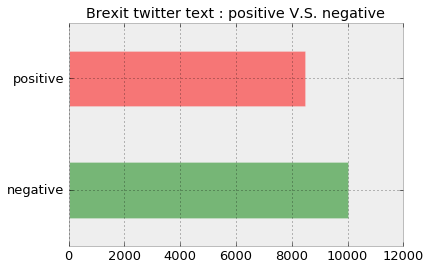

In [225]:
print ratio/ratio.sum()
ratio.plot.barh(fontsize = 13, title = 'Brexit twitter text : positive V.S. negative', alpha = 0.5, color = 'gr')
plt.show()

In [58]:
test_data_df_neg = test_data_df[test_data_df['predict'] == 'negative']
test_data_df_pos = test_data_df[test_data_df['predict'] == 'positive']
test_data_df_neg.head()

,text,cleaned_text,predict,language
1,RT @reddoorsound: #WelcomeinAberdeen #diversit...,reddoorsound welcomeinaberdeen diversity uoamu...,negative,de
2,Something to make #Leave voters think...! #Bre...,something make leave voters think britain brem...,negative,en
3,RT @DerekBateman2: So the Tories lead us out o...,derekbateman2 tories lead wreck economy chase ...,negative,en
4,@sporan1314 @SayYesToIndy @alexreid2000 @Gordo...,sporan1314 sayyestoindy alexreid2000 gordonmcneil,negative,af
5,RT @pppaolo: #BREXIT New data shows that only ...,pppaolo new data shows remainers 18-24 year ol...,negative,en


In [59]:
test_neg_list = test_data_df_neg.cleaned_text.tolist()
test_neg_list = ','.join(test_neg_list)

In [60]:
test_pos_list = test_data_df_pos.cleaned_text.tolist()
test_pos_list = ','.join(test_pos_list)

In [61]:
import nltk
tokens_pos = nltk.word_tokenize(test_pos_list)
tokens_pos[10:30]

[u'e.u',
 u'.',
 u'writes',
 u'furchtgottroth,100s',
 u'stories',
 u'per',
 u'day',
 u'give',
 u'top',
 u'ukineu',
 u',',
 u'kenneththarp',
 u's\xe9gol\xe8ne',
 u'royal',
 u'french',
 u'environment',
 u'minister',
 u'watch',
 u',',
 u'markcooperxyz']

In [62]:
def clean_tokens(tokens):
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                   (token.lower() not in english_stops) and len(token) > 4]

In [63]:
tokens_pos = clean_tokens(tokens_pos)

In [64]:
from nltk import Text
text_pos = Text(tokens_pos)
text_pos.vocab().most_common()[0:15]

[(u'britain', 281),
 (u'euref', 262),
 (u'remain', 250),
 (u'andrealeadsom', 242),
 (u'people', 222),
 (u'world', 220),
 (u'economy', 190),
 (u'leave', 184),
 (u'business', 176),
 (u'article', 172),
 (u'scotland', 163),
 (u'london', 163),
 (u'great', 159),
 (u'theresa', 148),
 (u'trade', 144)]

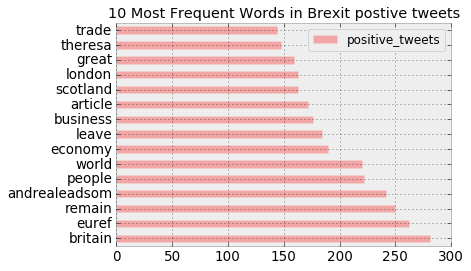

In [228]:
pos_15 = text_pos.vocab().most_common()[0:15]
name = [x[0] for x in pos_15]
num = [x[1] for x in pos_15]
pos_data = pd.DataFrame({'positive_tweets':num}, index=name)

pos_data.plot.barh(title='10 Most Frequent Words in Brexit postive tweets', alpha = 0.3, color = 'r', fontsize=13.5)

In [66]:
import nltk
tokens_neg = nltk.word_tokenize(test_neg_list)
tokens_neg[10:30]

[u'think',
 u'britain',
 u'bremain',
 u'england',
 u'scotland',
 u'europeanunion',
 u',',
 u'derekbateman2',
 u'tories',
 u'lead',
 u'wreck',
 u'economy',
 u'chase',
 u'businesses',
 u'investment',
 u'away',
 u'yet',
 u'blame',
 u'snp',
 u',']

In [189]:
tokens_neg = clean_tokens(tokens_neg)

In [190]:
from nltk import Text
text_neg = Text(tokens_neg)
text_neg.vocab().most_common()[0:15]

[(u'people', 391),
 (u'leave', 338),
 (u'england', 270),
 (u'europe', 263),
 (u'voted', 261),
 (u'farage', 248),
 (u'euref', 235),
 (u'britain', 207),
 (u'london', 198),
 (u'british', 194),
 (u'right', 194),
 (u'daily', 178),
 (u'capital', 178),
 (u'banks', 172),
 (u'referendum', 170)]

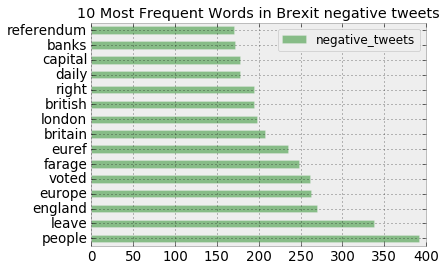

In [226]:
neg_15 = text_neg.vocab().most_common()[0:15]
name = [x[0] for x in neg_15]
num = [x[1] for x in neg_15]
neg_data = pd.DataFrame({'negative_tweets':num}, index=name)

neg_data.plot.barh(title='10 Most Frequent Words in Brexit negative tweets', alpha = 0.5, color = 'forestgreen', fontsize=13.5)


#### 对全部的文本内容进行清理，用于后面的词云建立和话题分析

In [255]:
test_cluster = ','.join(test_data_df.cleaned_text.tolist())
tokens_cluster = nltk.word_tokenize(test_cluster)
tokens_cluster[10:30]

[(u'theresa', 672),
 (u'leadsom', 215),
 (u'andrea', 196),
 (u'business', 191),
 (u'leadership', 142),
 (u'michael', 138),
 (u'backers', 116),
 (u'urges', 114),
 (u'deepens', 111),
 (u'civil', 110),
 (u'block', 101),
 (u'chilcot', 97)]

In [166]:
tokens_cluster = clean_tokens(tokens_cluster)
tokens_cluster[10:25]

[u'something',
 u'leave',
 u'voters',
 u'think',
 u'britain',
 u'bremain',
 u'england',
 u'scotland',
 u'europeanunion',
 u'derekbateman2',
 u'tories',
 u'wreck',
 u'economy',
 u'chase',
 u'businesses']

In [167]:
from nltk import Text
text_cluster = Text(tokens_cluster)
text_cluster.vocab().most_common()[0:20]

[(u'people', 614),
 (u'leave', 522),
 (u'euref', 497),
 (u'britain', 488),
 (u'remain', 405),
 (u'voted', 390),
 (u'europe', 369),
 (u'london', 361),
 (u'england', 358),
 (u'farage', 348),
 (u'andrealeadsom', 342),
 (u'british', 316),
 (u'business', 294),
 (u'economy', 290),
 (u'right', 283),
 (u'scotland', 278),
 (u'world', 276),
 (u'referendum', 271),
 (u'theresa', 233),
 (u'country', 230)]

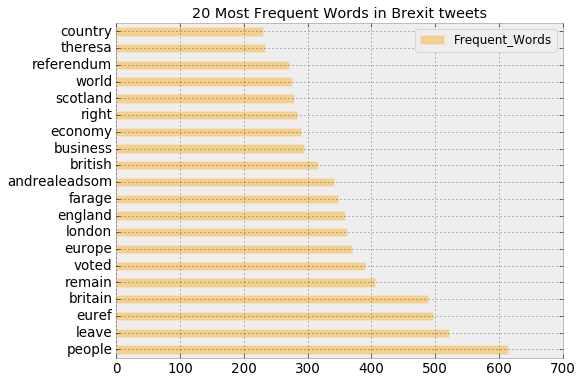

In [302]:
total = text_cluster.vocab().most_common()[0:20]
name = [x[0] for x in total]
num = [x[1] for x in total]
total_20 = pd.DataFrame({'Frequent_Words':num}, index=name)
total_20.plot.barh(figsize = (8,6), title='20 Most Frequent Words in Brexit tweets', color = 'orange', alpha = 0.4, fontsize=13.5)

### 对部分关键词进行情感分析
#### therasa

In [271]:
from nltk.twitter.common import json2csv
with open('theresa.json') as fp:
    json2csv(fp, 'theresa.csv',
            ['created_at','text'])

In [274]:
therasa.head()

,created_at,text,cleaned_text
0,Thu Jul 07 06:24:22 +0000 2016,"#brexit It’s Not Just The Brexit, Stupid! 👍",it’s stupid
1,Thu Jul 07 06:24:23 +0000 2016,RT @MisterWEO: Heres Europes Answer to the Mes...,misterweo heres europes answer mess left europ...
2,Thu Jul 07 06:24:23 +0000 2016,RT @DVATW: If the current Government is nit pr...,dvatw current government nit prepared deliver ...
3,Thu Jul 07 06:24:25 +0000 2016,"#Brexit : ""Nous avons une carte à jouer, il fa...",nous avons une carte jouer faut valoriser nos ...
4,Thu Jul 07 06:24:25 +0000 2016,RT @HowShouldWeVote: If Britain slips to 6th l...,howshouldwevote britain slips 6th largest econ...


In [272]:
therasa = pd.read_csv('theresa.csv', encoding = 'utf8')
therasa['text'] =therasa['text'].map(lambda x: re.sub('http.+', '', x))

def clean(tokens):
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                   (token.lower() not in english_stops) and len(token) > 2]

therasa['cleaned_text'] = therasa['text'].map(lambda x: nltk.word_tokenize(x))
therasa['cleaned_text'] = therasa['cleaned_text'].map(lambda x: clean(x))
therasa['cleaned_text'] = therasa['cleaned_text'].map(lambda x: ' '.join(x))

therasa[1999:2000]

,created_at,text,cleaned_text
1999,Thu Jul 07 06:49:43 +0000 2016,"RT @UKIPPOOLE: May is always reactive, never p...",ukippoole always reactive never proactive andr...


In [279]:
therasa_speed = (float(therasa.iloc[1999,0][14:16])-float(therasa.iloc[0,0][14:16]))/2000
therasa_speed 

0.0125

In [246]:
from guess_language import guessLanguage
therasa['language'] = therasa['text'].map(lambda x: guessLanguage(x))
therasa_en = therasa[therasa['language'] == 'en']
therasa_en = therasa_en[:1500]

In [248]:
therasa_en.head()

,created_at,text,cleaned_text,language
0,Thu Jul 07 06:24:22 +0000 2016,"#brexit It’s Not Just The Brexit, Stupid! 👍",it’s stupid,en
1,Thu Jul 07 06:24:23 +0000 2016,RT @MisterWEO: Heres Europes Answer to the Mes...,misterweo heres europes answer mess left europ...,en
2,Thu Jul 07 06:24:23 +0000 2016,RT @DVATW: If the current Government is nit pr...,dvatw current government nit prepared deliver ...,en
4,Thu Jul 07 06:24:25 +0000 2016,RT @HowShouldWeVote: If Britain slips to 6th l...,howshouldwevote britain slips 6th largest econ...,en
5,Thu Jul 07 06:24:27 +0000 2016,"RT @thalestral: Theresa May, Conservative lead...",thalestral theresa conservative leader candida...,en


#### 文本情感分析

In [251]:
therasa_en['predict'] = therasa_en['cleaned_text'].map(lambda x: classifier.classify(extract_features(x.split())))

#### 可视化

In [258]:
tr = therasa_en['predict'].value_counts()

positive    0.521333
negative    0.478667
Name: predict, dtype: float64


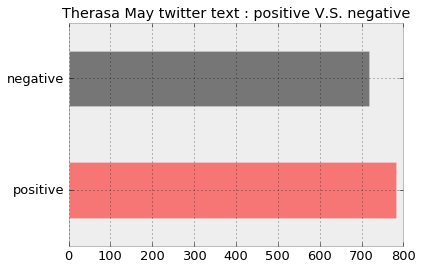

In [265]:
print tr/tr.sum()
tr.plot.barh(fontsize = 13, title = 'Therasa May twitter text : positive V.S. negative', alpha = 0.5, color = 'rk')
plt.show()

In [292]:
from nltk import Text
the_cluster = ','.join(therasa.cleaned_text.tolist())
therasa_cluster = nltk.word_tokenize(the_cluster)
therasa_cluster = clean_tokens(therasa_cluster)

text_therasa = Text(therasa_cluster)
text_therasa.vocab().most_common()[1:13]

[(u'leadsom', 215),
 (u'andrea', 196),
 (u'business', 191),
 (u'leadership', 142),
 (u'michael', 138),
 (u'backers', 116),
 (u'urges', 114),
 (u'deepens', 111),
 (u'civil', 110),
 (u'block', 101),
 (u'chilcot', 97),
 (u'britain', 94)]

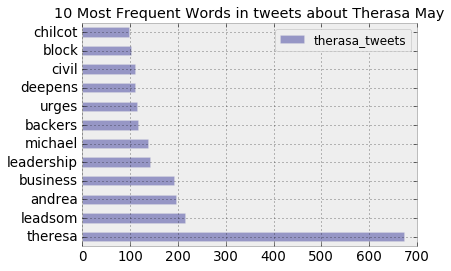

In [297]:
the_12 = text_therasa.vocab().most_common()[0:12]
name = [x[0] for x in the_12]
num = [x[1] for x in the_12]
the_data = pd.DataFrame({'therasa_tweets':num}, index=name)
the_data.plot.barh(title='10 Most Frequent Words in tweets about Therasa May', alpha = 0.37, color = 'navy', fontsize=13.5)

#### andrea

In [267]:
from nltk.twitter.common import json2csv
from guess_language import guessLanguage
with open('andrealeadsom.json') as fp:
    json2csv(fp, 'andrea.csv',
            ['created_at','text'])
    
andrea = pd.read_csv('andrea.csv', encoding = 'utf8')
andrea['text'] = andrea['text'].map(lambda x: re.sub('http.+', '', x))

def clean(tokens):
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                   (token.lower() not in english_stops) and len(token) > 2]

andrea['cleaned_text'] = andrea['text'].map(lambda x: nltk.word_tokenize(x))
andrea['cleaned_text'] = andrea['cleaned_text'].map(lambda x: clean(x))
andrea['cleaned_text'] = andrea['cleaned_text'].map(lambda x: ' '.join(x))

andrea[1999:2000]

,created_at,text,cleaned_text
1999,Thu Jul 07 08:34:30 +0000 2016,RT @NinaDSchick: Germany's EU Commissioner see...,ninadschick germany commissioner sees 'mortal ...


In [281]:
andrea_speed = (float(andrea.iloc[1999,0][14:16])-float(andrea.iloc[0,0][14:16]))/2000
print andrea_speed

andrea['language'] = andrea['text'].map(lambda x: guessLanguage(x))
andrea_en = andrea[andrea['language'] == 'en']
andrea_en = andrea_en[:1500]

0.009


In [285]:
andrea_en.head()

,created_at,text,cleaned_text,language,predict
0,Thu Jul 07 08:16:49 +0000 2016,RT @RaheemKassam: She's right. She's not smart...,raheemkassam right smart enough wilfully trait...,en,positive
3,Thu Jul 07 08:16:50 +0000 2016,RT @SimonMAtkinson: NEW post #Brexit @IpsosMRB...,simonmatkinson new post ipsosmrbi poll irish p...,en,positive
4,Thu Jul 07 08:16:50 +0000 2016,Lesson from Chilcot: don't make huge decisions...,lesson chilcot make huge decisions without pla...,en,positive
5,Thu Jul 07 08:16:51 +0000 2016,"RT @acgrayling: Chilcot and #Brexit: ""Chilcot ...",acgrayling chilcot chilcot begs gvt never emba...,en,negative
8,Thu Jul 07 08:16:52 +0000 2016,RT @KAlmsivi: UK votes to leave EU because the...,kalmsivi votes leave many foreigners taking jo...,en,negative


#### 文本情感分析

In [286]:
andrea_en['predict'] = andrea_en['cleaned_text'].map(lambda x: classifier.classify(extract_features(x.split())))

#### 可视化

positive    0.516
negative    0.484
Name: predict, dtype: float64


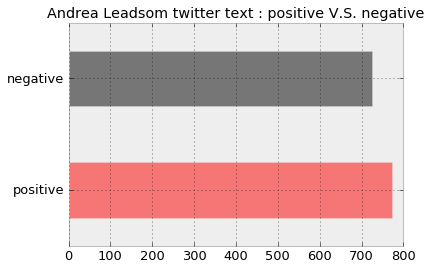

In [287]:
ad = andrea_en['predict'].value_counts()
print ad/ad.sum()
ad.plot.barh(fontsize = 13, title = 'Andrea Leadsom twitter text : positive V.S. negative', alpha = 0.5, color = 'rk')
plt.show()

In [293]:
from nltk import Text
adr_cluster = ','.join(andrea.cleaned_text.tolist())
andrea_cluster = nltk.word_tokenize(adr_cluster)
andrea_cluster = clean_tokens(andrea_cluster)

text_andrea = Text(andrea_cluster)
text_andrea.vocab().most_common()[1:13]

[(u'london', 108),
 (u'prices', 108),
 (u'property', 107),
 (u'business', 101),
 (u'luxury', 85),
 (u'plummet', 84),
 (u'marcosecchi', 83),
 (u'today', 79),
 (u'people', 55),
 (u'britain', 51),
 (u'world', 50),
 (u'democracy', 47)]

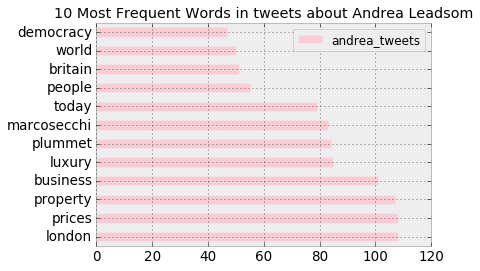

In [301]:
adr_12 = text_andrea.vocab().most_common()[1:13]
name = [x[0] for x in adr_12]
num = [x[1] for x in adr_12]
adr_data = pd.DataFrame({'andrea_tweets':num}, index=name)
adr_data.plot.barh(title='10 Most Frequent Words in tweets about Andrea Leadsom', alpha = 0.7, color = 'pink', fontsize=13.5)

### 发推用户分布分析
不同国家地区的用户发推量排名

  分析：可以看出，本次分析中，英国脱欧推文排名前 10 的国家为欧
  美国家。英国脱欧公投对即将到来的美国大选有一定的借鉴意义,
  发推排名中也有相应显示，美国的相关发推量第二。


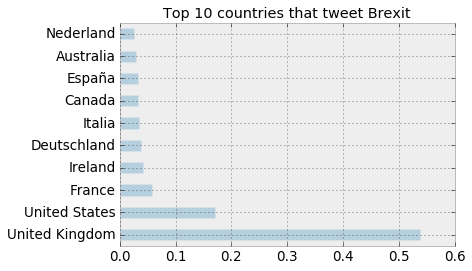

In [303]:
df_place = pd.read_csv('place_bounding_box.csv')
df_country = pd.read_csv('tweets_brexit_place.csv')
df_place['country'] = df_country['place.country']

country_10 = df_place.country.value_counts()[0:10]
country_10_ratio = country_10/country_10.sum()

from matplotlib.font_manager import FontProperties
yahei = FontProperties(fname=r"/Library/Fonts/msyh.ttf") 
country_10_ratio.plot.barh(title = 'Top 10 countries that tweet Brexit', alpha = 0.3, fontsize = 13.5)
print u'  分析：可以看出，本次分析中，英国脱欧推文排名前 10 的国家为欧'
print u'  美国家。英国脱欧公投对即将到来的美国大选有一定的借鉴意义,'
print u'  发推排名中也有相应显示，美国的相关发推量第二。'

### Basemap 发推用户分布地图可视化

In [304]:
import ast
df_place['bounding_box_coordinates'] = df_place['bounding_box.coordinates'].map(lambda x:ast.literal_eval(x)[0])

df_place['lon'] = df_place['bounding_box_coordinates'].map(lambda x:x[0])
df_place['lat'] = df_place['bounding_box_coordinates'].map(lambda x:x[1])
df_place = df_place.drop('bounding_box.coordinates', 1)

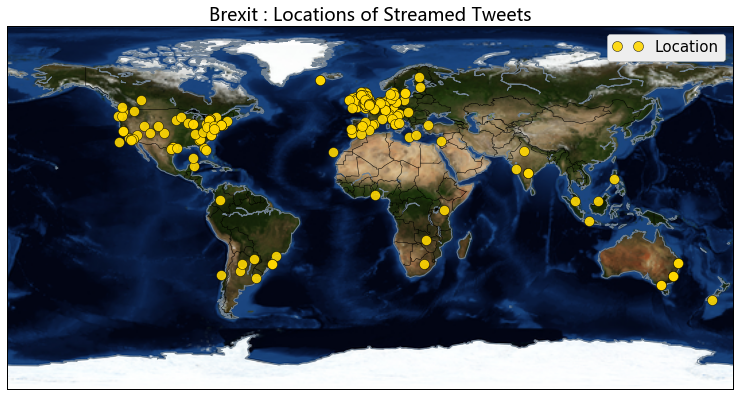

In [305]:
%matplotlib inline 
from mpl_toolkits.basemap import Basemap
 
plt.figure(figsize=(13, 13))

font = FontProperties(fname=r"/Library/Fonts/msyh.ttf") 

map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
map.drawcoastlines(color='slategrey')
map.drawcountries()
map.drawmapboundary()
map.bluemarble(scale = 0.1)

x,y = map(list(df_place['lon']), list(df_place['lat']))
map.plot(x,y, 'bo', markersize = 10, color = 'gold', alpha = 0.9, label= 'Location')

plt.title("Brexit : Locations of Streamed Tweets", size = 18, fontproperties=font)
plt.legend(prop={'size':15})
plt.show()

### 词云 ☁️ 可视化

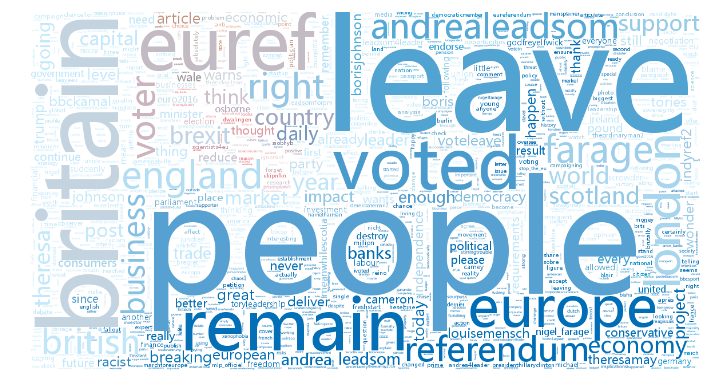

In [163]:
import matplotlib.pyplot as plt
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

words = twitter_word_string 

word = " ".join([word for word in words.split()
                            if (word not in string.punctuation)
                             and (len(word) > 4)         
                            ])

breixt_mask = imread('brexit.png')

wordcloud = WordCloud(
                      font_path=r"/Library/Fonts/msyh.ttf",
                      stopwords=STOPWORDS,
                      background_color='white',
                      mask=breixt_mask,
                      width=1800,
                      height=1400,
                      max_words=3000,
                     ).generate(word)

image_colors = ImageColorGenerator(breixt_mask)

plt.figure(figsize = (12, 20))
plt.imshow(wordcloud.recolor(color_func=image_colors),aspect='equal')
plt.axis('off')
plt.savefig('./brexit_twitter_wordcloud_1.png', dpi=400)
plt.show()

### 主题模型
- 建立主题模型，建模方法为 Latent Dirichlet Allocation (LDA)
- 观察反复捆绑出现的词汇，推测主题

In [86]:
test_data_df.head()

,text,cleaned_text,predict,language
0,RT @KateWilliamsme: A brilliant article on #Br...,katewilliamsme brilliant article kazuo ishiguro,positive,en
1,RT @reddoorsound: #WelcomeinAberdeen #diversit...,reddoorsound welcomeinaberdeen diversity uoamu...,negative,de
2,Something to make #Leave voters think...! #Bre...,something make leave voters think britain brem...,negative,en
3,RT @DerekBateman2: So the Tories lead us out o...,derekbateman2 tories lead wreck economy chase ...,negative,en
4,@sporan1314 @SayYesToIndy @alexreid2000 @Gordo...,sporan1314 sayyestoindy alexreid2000 gordonmcneil,negative,af


In [312]:
import lda 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# 创建二维向量
vect = CountVectorizer(stop_words='english', ngram_range=[1,3]) 
sentences_train = vect.fit_transform(np.array(test_data_df.cleaned_text.tolist()))

# 初始化LDA模型
model = lda.LDA(n_topics=10, n_iter=500)
model.fit(sentences_train) # Fit the model 
n_top_words = 11
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vect.get_feature_names())[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i+1, ', '.join(topic_words)))

Topic 1: minister, free, country, scotland, people, far, prime, prime minister, happen, british
Topic 2: people, want, voted, time, support, trade, theordinaryman2, global, andrea4leader, better
Topic 3: let, make, deliver, london, leadsom, good, opportunities, andrea leadsom, impact, andrea
Topic 4: england, bank, vote, bank england, banks, breaking, capital, high, euref, warns
Topic 5: vote, project, britain, week, law, fact, fear, remain, turns, united
Topic 6: news, gove, time, remain, johnson, got, farage, years, place, let
Topic 7: vote, want, farage, week, ukip, leave, negotiations, english, voted, britain
Topic 8: right, remain, leave, know, feel, says, wonder, voters, thinking, scrowder
Topic 9: people, meanwhilescotia, know, businesses, tories, indyref2, game, blame, away, economy
Topic 10: vote, going, world, leave, economy, old, remember, destroy, theresa, britain


In [88]:
Topic_1 = 'minister, free, country, scotland, people, far, prime, prime minister, happen, british'
Topic_2 = 'people, want, voted, time, support, trade, theordinaryman2, global, andrea4leader, better'
Topic_3 = 'let, make, deliver, london, leadsom, good, opportunities, andrea leadsom, impact, andrea'
Topic_4 = 'england, bank, vote, bank england, banks, breaking, capital, high, euref, warns'
Topic_5 = 'vote, project, britain, week, law, fact, fear, remain, turns, united'
Topic_6 = 'news, gove, time, remain, johnson, got, farage, years, place, let'
Topic_7 = 'vote, want, farage, week, ukip, leave, negotiations, english, voted, britain'
Topic_8 = 'right, remain, leave, know, feel, says, wonder, voters, thinking, scrowder'
Topic_9 = 'people, meanwhilescotia, know, businesses, tories, indyref2, game, blame, away, economy'
Topic_10 =  'vote, going, world, leave, economy, old, remember, destroy, theresa, britain'

In [102]:
topic = [Topic_1, Topic_2, Topic_3, Topic_4, Topic_5, Topic_6, Topic_7, Topic_8, Topic_9, Topic_10]
topic = [re.sub(',', '', x) for x in topic]
topic

['minister free country scotland people far prime prime minister happen british',
 'people want voted time support trade theordinaryman2 global andrea4leader better',
 'let make deliver london leadsom good opportunities andrea leadsom impact andrea',
 'england bank vote bank england banks breaking capital high euref warns',
 'vote project britain week law fact fear remain turns united',
 'news gove time remain johnson got farage years place let',
 'vote want farage week ukip leave negotiations english voted britain',
 'right remain leave know feel says wonder voters thinking scrowder',
 'people meanwhilescotia know businesses tories indyref2 game blame away economy',
 'vote going world leave economy old remember destroy theresa britain']

In [116]:
def word_cloud(i):
    words = topic[i] 

    breixt_mask = imread('bulb.png')

    wordcloud = WordCloud(
                      font_path=r"/Library/Fonts/msyh.ttf",
                      stopwords=STOPWORDS,
                      background_color='white',
                      mask=breixt_mask,
                      width=1800,
                      height=1400,
                      max_words=3000,
                     ).generate(words)

    image_colors = ImageColorGenerator(breixt_mask)
    print topic[i]
    plt.figure(figsize = (12, 20))
    plt.imshow(wordcloud.recolor(color_func=image_colors),aspect='equal')
    plt.axis('off')
    plt.show()

minister free country scotland people far prime prime minister happen british


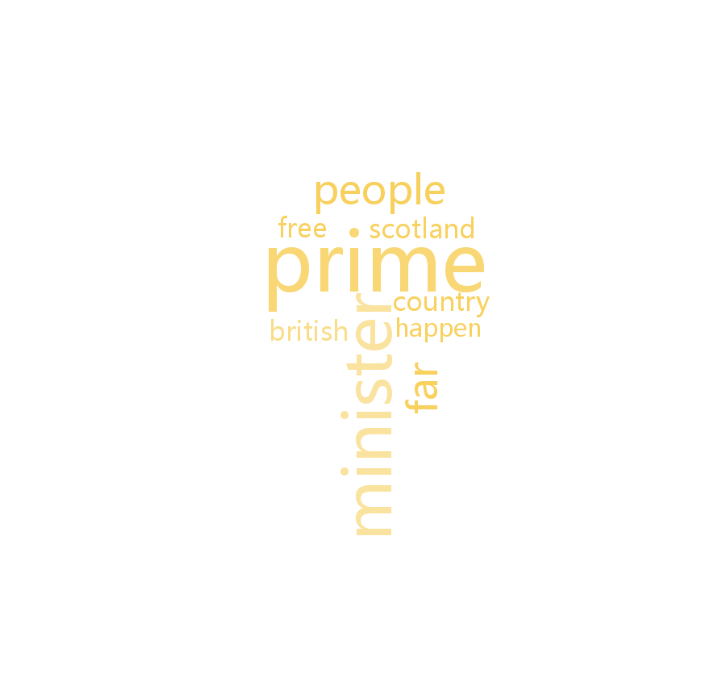

people want voted time support trade theordinaryman2 global andrea4leader better


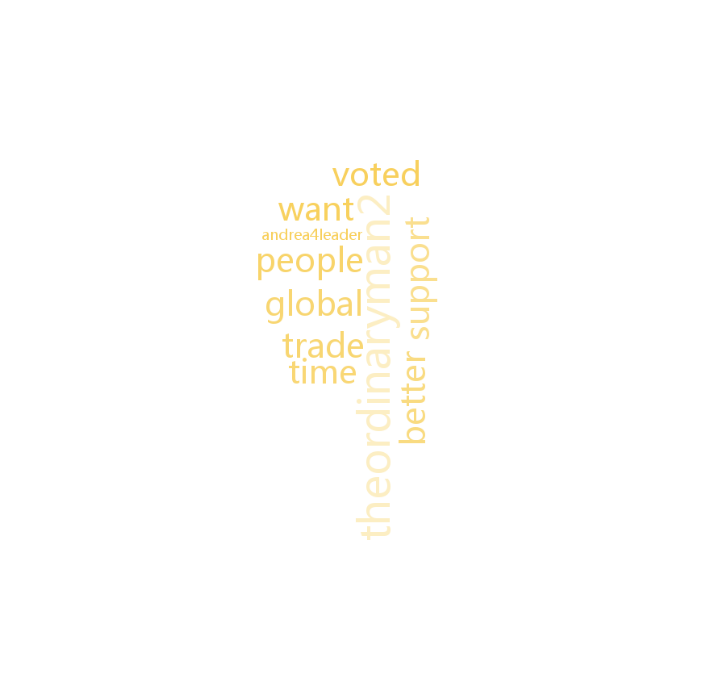

let make deliver london leadsom good opportunities andrea leadsom impact andrea


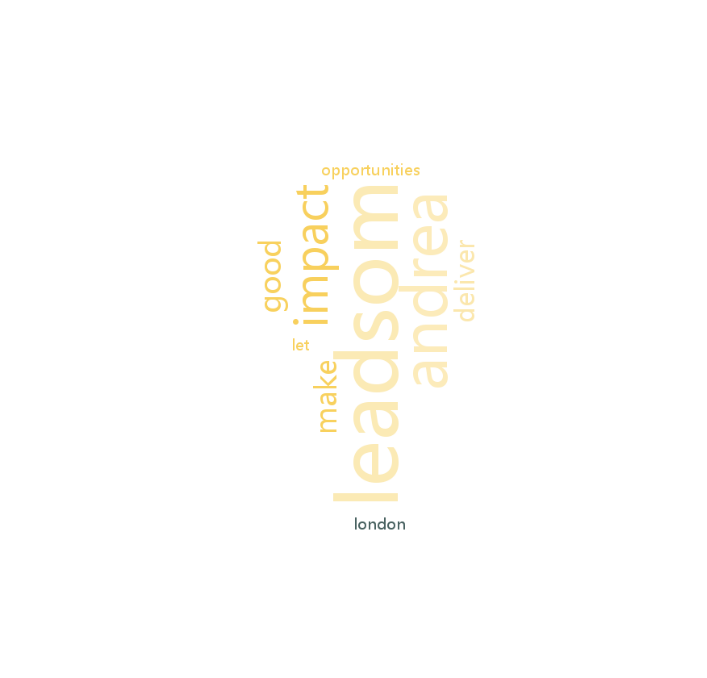

england bank vote bank england banks breaking capital high euref warns


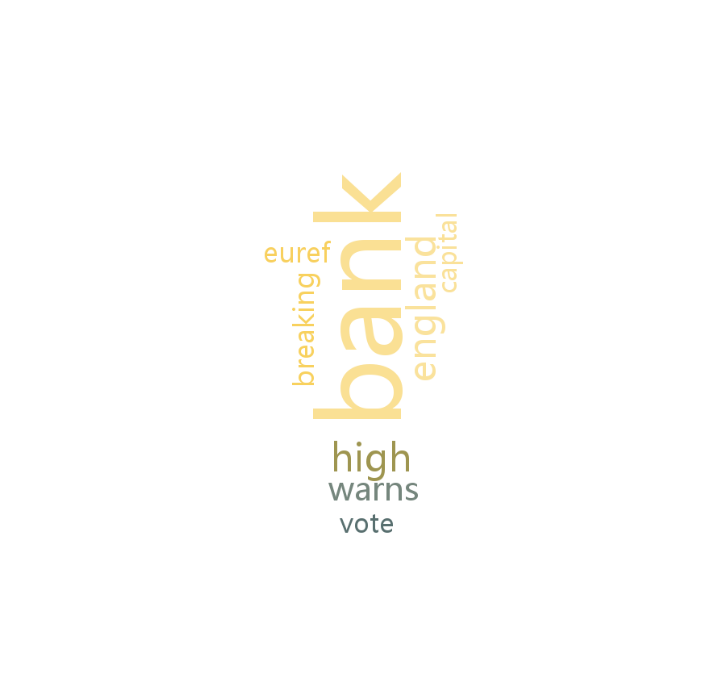

vote project britain week law fact fear remain turns united


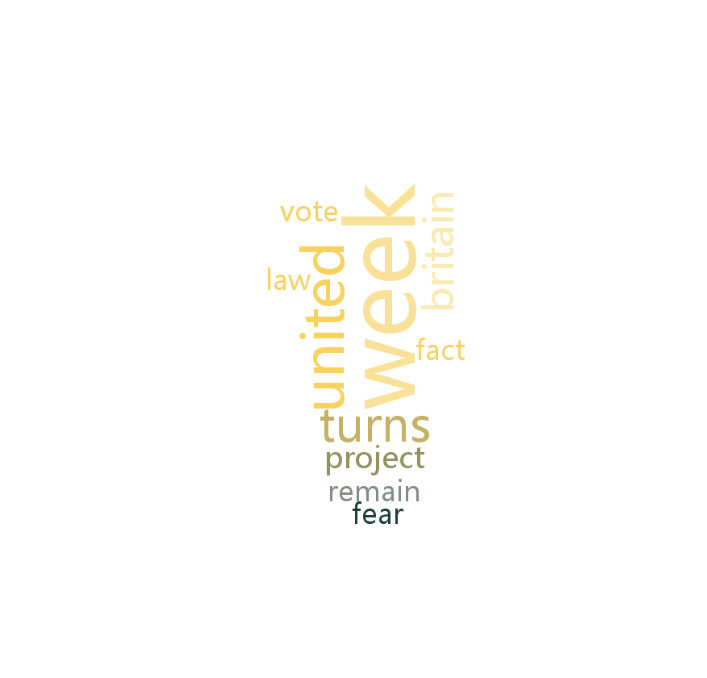

news gove time remain johnson got farage years place let


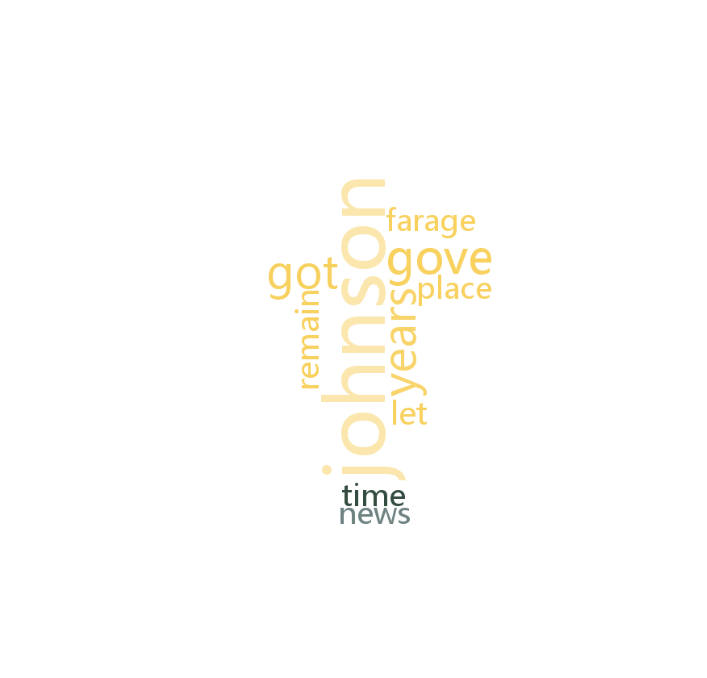

vote want farage week ukip leave negotiations english voted britain


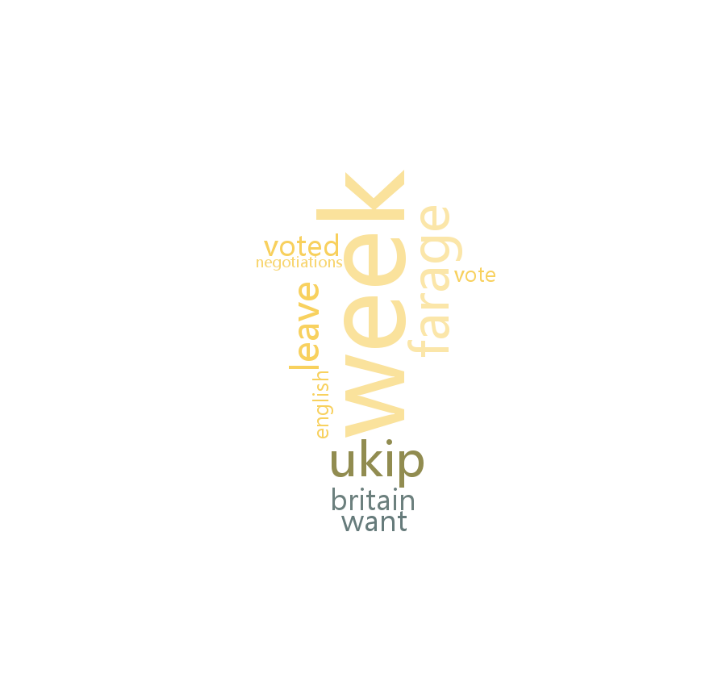

right remain leave know feel says wonder voters thinking scrowder


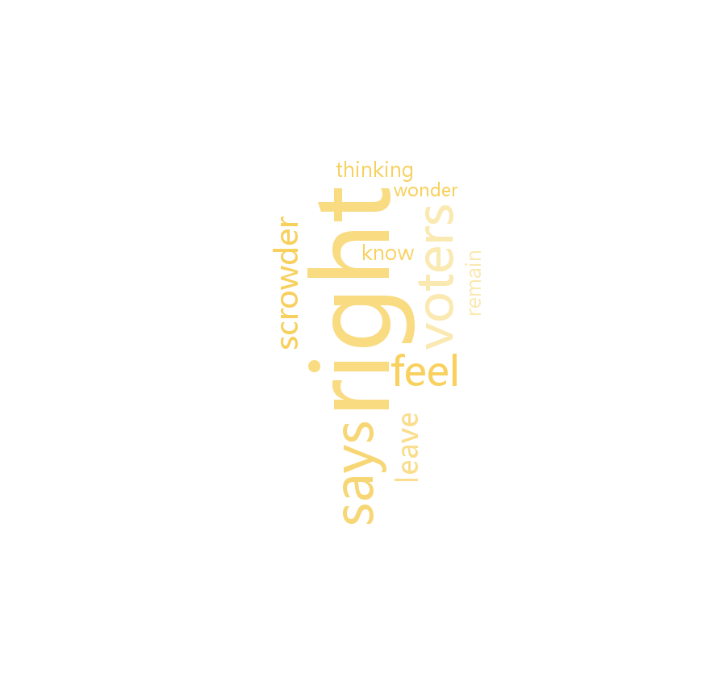

people meanwhilescotia know businesses tories indyref2 game blame away economy


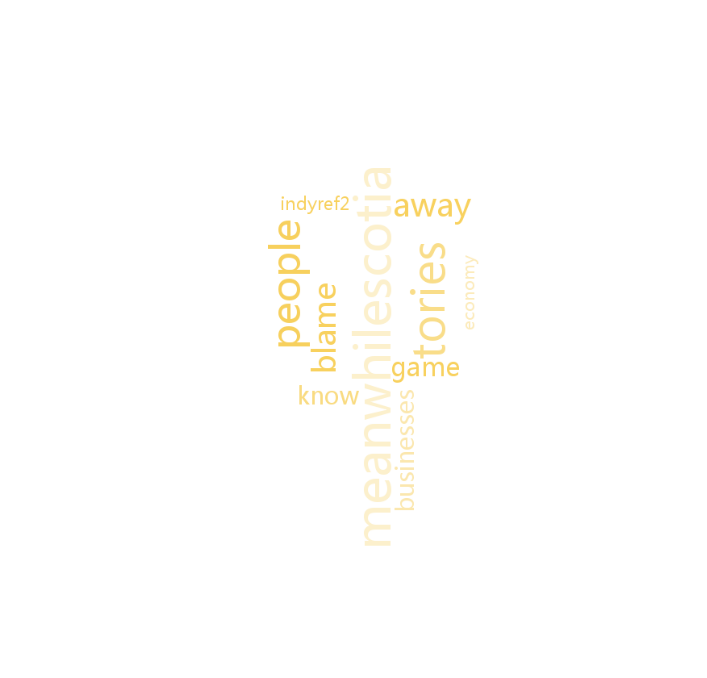

vote going world leave economy old remember destroy theresa britain


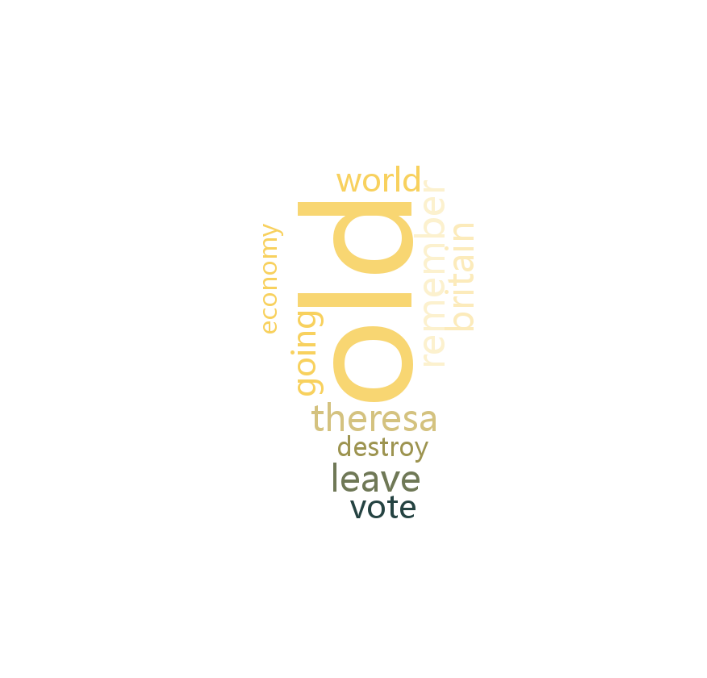

In [117]:
for i in range(10):
    word_cloud(i)